In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp

# Read File

In [2]:
df = pd.read_csv('seattleWeather_1948-2017.csv')

In [3]:
print(df.head(5))

         DATE  PRCP  TMAX  TMIN  RAIN
0  1948-01-01  0.47    51    42  True
1  1948-01-02  0.59    45    36  True
2  1948-01-03  0.42    45    35  True
3  1948-01-04  0.31    45    34  True
4  1948-01-05  0.17    45    32  True


In [8]:
print(df.shape)

25551


# Obtain Year

In [18]:
year_date = np.zeros(df.shape[0], dtype=np.int)
for i in range(df.shape[0]):
    year_date[i]= pd.to_datetime(df.DATE[i]).year
year_new = np.unique(year_date)

In [19]:
print(year_new)

[1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


In [14]:
year = pd.DataFrame(year_date, columns=['YEAR'])

In [15]:
df_new = pd.concat([df, year], axis=1)

In [17]:
print(df_new.head(5))

         DATE  PRCP  TMAX  TMIN  RAIN  YEAR
0  1948-01-01  0.47    51    42  True  1948
1  1948-01-02  0.59    45    36  True  1948
2  1948-01-03  0.42    45    35  True  1948
3  1948-01-04  0.31    45    34  True  1948
4  1948-01-05  0.17    45    32  True  1948


# Sum Precipitation for each year

In [20]:
prcp = np.zeros(year_new.shape[0])
for i in range(year_new.shape[0]):
    prcp[i] = format(df_new.loc[df_new['YEAR'] == year_new[i], 'PRCP'].sum(), '0.2f')

In [21]:
print(prcp)

[45.79 32.46 55.14 40.3  23.78 49.42 41.27 46.61 36.85 34.63 42.63 46.52
 39.28 42.53 35.79 38.72 41.34 33.56 38.23 35.58 50.15 33.73 37.41 43.21
 48.36 35.04 37.87 44.48 26.7  32.84 33.99 32.26 35.6  35.4  39.32 40.93
 36.99 25.13 38.34 29.93 32.98 34.69 44.75 35.42 32.78 28.8  34.82 42.6
 50.67 43.26 44.06 42.11 28.66 37.56 31.36 41.78 31.1  35.44 48.42 38.95
 30.73 38.44 46.99 36.39 48.26 32.56 48.5  44.83 45.18 43.55]


In [22]:
total = pd.concat([pd.DataFrame(year_new, columns=['Year']), pd.DataFrame(prcp, columns=['Total_P'])], axis=1 )

# Calculate the Return Year

In [23]:
max_rain = df_new.groupby(['YEAR'])['PRCP'].max().reset_index()

In [24]:
sort_rain = max_rain.sort_values(by =['PRCP'], ascending=False).reset_index(drop=True)

In [25]:
rank = np.zeros((len(sort_rain), 3))
for i in range(len(sort_rain)):
    rank[i, 0] = i + 1
    rank[i, 1] = (i + 1)/(len(sort_rain)+1)
    rank[i, 2] = 1/rank[i, 1]

rank = pd.DataFrame(rank, columns=['rank', 'probability', 'return_year'])
rank[['rank', 'return_year']] = rank[['rank', 'return_year']].astype(int)
rank_rain = pd.concat([sort_rain, rank], axis=1)

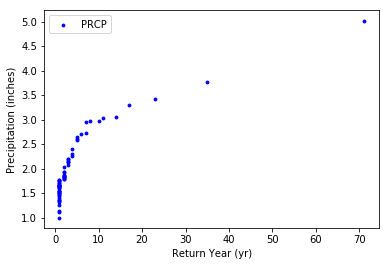

In [26]:
plt.scatter(rank_rain['return_year'], rank_rain['PRCP'], s=8, color = 'b')
plt.legend()
plt.xlabel('Return Year (yr)')
plt.ylabel('Precipitation (inches)')
plt.show()

# Build three model

In [31]:
rain = np.array(rank_rain['PRCP'])
std = np.std(rain)
u = np.mean(rain)
skew = sp.skew(np.log10(rain))
re_year = np.array(rank_rain['return_year'])

In [32]:
z = np.zeros(len(re_year))
k3 = np.zeros(len(re_year))
lp3 = np.zeros(len(re_year))

for i in range(len(k3)):
    if re_year[i] != 1:
        z[i] = sp.norm.ppf(1-(1/re_year[i]))
        k3[i] = -(np.sqrt(6)/np.pi)*(0.5772 + np.log(np.log(re_year[i]/(re_year[i]-1)))) 
    else:
        z[i] = sp.norm.ppf(1-(1/(re_year[i]+0.1)))
        k3[i] = -(np.sqrt(6)/np.pi)*(0.5772 + np.log(np.log((re_year[i]+0.1)/(re_year[i]+0.1-1))))
    lp3[i] = 2/skew * (np.power((z[i] - skew/6)*skew/6+1, 3)-1)

In [33]:
model_rain = np.zeros((len(rain), 3))
for i in range(len(model_rain)):
    model_rain[i][0] = u + z[i]* std
    model_rain[i][1] = u + k3[i] * std
    model_rain[i][2] = np.power(10, np.mean(np.log10(rain)) + lp3[i] * np.std(np.log10(rain)))
pd_rain = pd.DataFrame(model_rain, columns=['Normal', 'Gumbel', 'LogPerason'])
total_rain = pd.concat([pd_rain, rank_rain], axis=1)
print(total_rain.head(5))

     Normal    Gumbel  LogPerason  YEAR  PRCP  rank  probability  return_year
0  3.496118  3.958257    4.194639  2003  5.02     1     0.014085           71
1  3.295153  3.575661    3.668722  2007  3.77     2     0.028169           35
2  3.164332  3.346791    3.376021  1959  3.41     3     0.042254           23
3  3.063441  3.180684    3.173122  2006  3.29     4     0.056338           17
4  2.995132  3.073180    3.045892  1996  3.06     5     0.070423           14


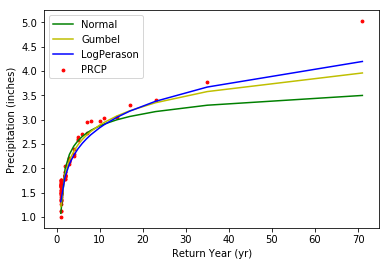

In [34]:
plt.plot(total_rain['return_year'], total_rain['Normal'], color = 'g')
plt.plot(total_rain['return_year'], total_rain['Gumbel'], color = 'y')
plt.plot(total_rain['return_year'], total_rain['LogPerason'], color = 'b')
plt.scatter(total_rain['return_year'], total_rain['PRCP'], s=8, color= 'r')
plt.legend()
plt.xlabel('Return Year (yr)')
plt.ylabel('Precipitation (inches)')
plt.show()

# Model Selection

In [36]:
se = np.zeros((len(total_rain), 3))
for i in range(len(total_rain)):
    se[i][0] = np.square(total_rain.PRCP[i]-total_rain.Normal[i])
    se[i][1] = np.square(total_rain.PRCP[i]-total_rain.Gumbel[i])
    se[i][2] = np.square(total_rain.PRCP[i]-total_rain.LogPerason[i])
mse = pd.DataFrame(np.average(se, axis=0), index=['Normal', 'Gumbel', 'Logperason'], columns=['MSE'])

In [56]:
print(mse)

                 MSE
Normal      0.166235
Gumbel      0.087722
Logperason  0.058394


In [55]:
print('The best model is', list(mse.idxmin()), 'and the MSE is', list(mse.min()))

The best model is ['Logperason'] and the MSE is [0.0583941583125492]
